In [2]:
!git clone https://github.com/AssemblyAI-Examples/mediapipe-python.git
!pip install mediapipe
!pip install PyQt5
!pip install ipython==7.32.0
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# JavaScript code to capture an image using the webcam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
CONFIDENCE = 0.7
NO_OF_CLASSES = 2
TARGET_SIZE = 256
face_detection = mp.solutions.face_detection
draw_utils = mp.solutions.drawing_utils
draw_color = draw_utils.DrawingSpec(color=(0, 255, 0), thickness=3, circle_radius=2)

Cloning into 'mediapipe-python'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 31.45 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (14/14), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.9/793.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency r

In [7]:
def get_bounding_rectangle(image, region, color, radius):
  height, width = image.shape[0:2]
  bounding_box = region.location_data.relative_bounding_box
  bounding_box = region.location_data.relative_bounding_box
  left = int(bounding_box.xmin * image.shape[1])
  top = int(bounding_box.ymin * image.shape[0])
  right = int((bounding_box.xmin + bounding_box.width) * image.shape[1])
  bottom = int((bounding_box.ymin + bounding_box.height) * image.shape[0])

  if left < 0:
      left = 0
  if top < 0:
      top = 0
  if right > width:
      right = width
  if bottom > height:
      bottom = height

  cv.rectangle(image, (left, top), (right, bottom), color, 1)

  cv.line(image, (left, top), (left, top + radius), color, 3)
  cv.line(image, (left, top), (left + radius, top), color, 3)

  cv.line(image, (right, top), (right, top + radius), color, 3)
  cv.line(image, (right, top), (right - radius, top), color, 3)

  cv.line(image, (left, bottom), (left, bottom - radius), color, 3)
  cv.line(image, (left, bottom), (left + radius, bottom), color, 3)

  cv.line(image, (right, bottom), (right, bottom - radius), color, 3)
  cv.line(image, (right, bottom), (right - radius, bottom), color, 3)

  return left, top, right, bottom


In [20]:
from google.colab.patches import cv2_imshow
import os
import glob
import cv2 as cv

def read_image_resize(dataset_folder, target_size, detection_module):

    images = []
    labels = []
    for directory in os.listdir(dataset_folder):
        #print(directory)

        path_dir = os.path.join(dataset_folder, directory)

        all_images = glob.glob(path_dir + "**/*.jpg")

        for image_file in all_images:


            image = cv.imread(image_file)

            image_convert = cv.cvtColor(image, cv.COLOR_BGR2RGB)

            outputs = detection_module.process(image_convert)

            if outputs.detections:

                 for region in outputs.detections:


                    left, top, right, bottom = get_bounding_rectangle(image,region, COLOR_GREEN, 2)

                    crop_image = image[top:bottom, left:right]


                    height, width = crop_image.shape[0:2]


                    image_resize = cv.resize(crop_image, (target_size, target_size))

                    h,w = image_resize.shape[0:2]

                    print (height, width)

                    if width < 50 or height < 50:
                      cv2_imshow(image_resize)
                      cv.waitKey(0)

                      cv2_imshow(image)
                      cv.waitKey(0)
                    else:
                      images.append(image_resize)
                      labels.append(directory)

    return images, labels

In [6]:
from sklearn.model_selection import train_test_split
def split_train_test(images, labels, testsize= 0.33, target_size=256, randomstate=1):

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size= testsize, random_state = randomstate)


    #2.4 Convert the images/dataset to numpy array
    x_train = np.array(x_train, dtype=object)
    x_test = np.array(x_test, dtype=object)

    #2.5 Reshape the array
    no_of_train = x_train.shape[0]
    no_of_test  = x_test.shape[0]

    print(x_train.shape)
    print(x_test.shape)

    x_train = x_train.reshape(no_of_train, target_size, target_size, 3)
    x_test  = x_test.reshape(no_of_test, target_size, target_size, 3)

    #print(x_train[0])

    #2.6 Convert array to float
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    #print(x_train[0])

    #2.7 Noramlized or scale - 0:1

    x_train /= 255
    x_test /= 255

    return x_train, x_test, y_train, y_test

In [24]:
from keras.utils import np_utils
def one_hot_encode(y_train, y_test, label_array, no_of_classes):
    y_train_keys=[]
    for y_label in y_train:
        values =    label_array[y_label]
        y_train_keys.append(values)

    y_test_keys=[]
    for y_label in y_test:
        values =    label_array[y_label]
        y_test_keys.append(values)

    y_train = np_utils.to_categorical(y_train_keys, no_of_classes)
    y_test = np_utils.to_categorical(y_test_keys, no_of_classes)

    return y_train, y_test

In [4]:
RIGHT_EYE = 0
LEFT_EYE = 1
NOSE_TIP = 2
MOUTH_CENTER = 3
RIGHT_EAR_TRAGION = 4
LEFT_EAR_TRAGION = 5

COLOR_GREEN = (0,255,0)
COLOR_RED = (0,0,255)
COLOR_BLUE = (255,0,0)

In [14]:
dataset_folder = "/content/drive/MyDrive/Dataset/train"


462 462
270 288
135 135
229 228
481 481
237 237
251 251
163 164
179 176
53 53
236 237
107 107
1408 1408
233 232
234 233
110 102
164 164
225 225
47 48


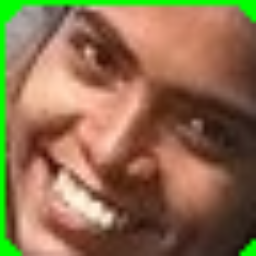

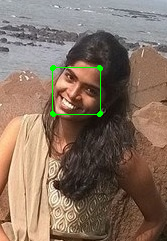

251 250
232 232
370 370
237 237
274 275
101 102
235 235
360 360
142 142
177 176
176 176
167 166
268 267
233 233
104 104
241 241
253 253
238 238
115 116
223 223
92 92
387 387
221 220
70 69
257 258
235 235
143 143
85 85
230 230
173 172
244 244
253 253
241 242
221 222
223 223
233 234
208 208
160 160
244 243
433 522
177 177
84 84
209 209
252 252
221 220
233 233
197 197
194 194
255 255
123 122
222 221
126 127
370 370
237 237
232 232
222 222
241 241
129 129
243 243
357 357
242 242
98 98
238 238
349 349
197 198
62 63
230 229
225 225
133 133
315 314
184 183
226 226
157 158
126 126
238 237
202 202
208 208
282 282
105 105
123 123
90 90
171 171
138 138
236 236
241 242
148 150
80 80
102 102
258 258
230 230
253 253
169 169
85 85
118 118
150 150
134 133
97 97
229 229
142 135
455 455
136 136
231 231
223 224
129 129
147 147
232 232
166 167
220 220
669 669
158 158
209 209
127 128
202 203
154 141
128 128
249 249
173 173
232 233
163 164
107 107
259 258
165 165
288 288
130 130
160 160
233 233
250 250
340 

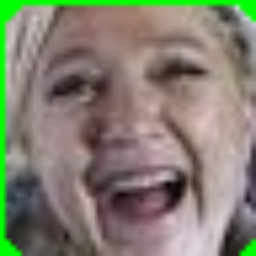

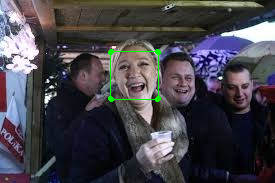

36 36


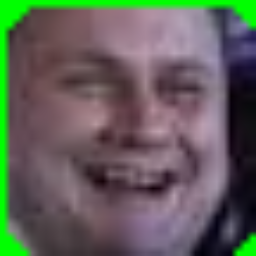

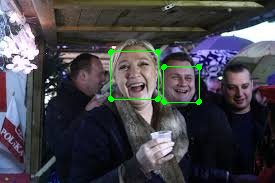

33 33


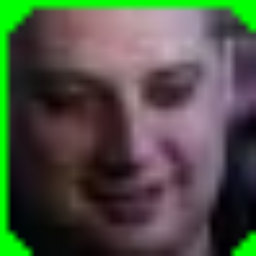

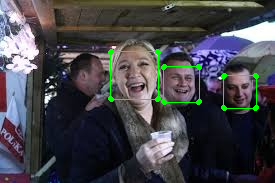

227 228
228 229
238 237
98 99
315 314
219 220
147 146
236 236
412 472
235 235
98 99
207 206
94 94
128 128
103 103
251 251
153 138
236 237
219 219
90 90
248 247
223 222
267 266
212 211
164 140
85 85
375 375
90 90
236 235
107 107
246 247
1490 1489
226 226
222 221
643 643
251 251
150 151
235 235
260 260
229 230
223 222
138 138
283 259
242 242
102 102
178 178
387 386
236 235
556 557
148 148
82 81
252 253
312 313
240 236
135 135
206 207
250 251
201 201
223 222
236 237
215 215
257 257
201 201
241 242
241 241
100 100
248 248
153 152
221 220
94 93
219 220
206 207
100 100
160 161
259 258
260 259
219 220
97 96
230 229
203 202
164 165
140 141
250 249
305 306
182 183
614 613
234 235
240 240
144 144
101 101
479 478
238 238
137 135
94 93
73 73
223 223
138 137
210 210
215 214
243 243
89 89
118 118
107 107
158 157
238 238
157 160
225 225
224 224
259 259
115 115
143 143
240 240
85 85
105 105
257 257
158 141
240 241
232 231
146 145
458 458
226 227
105 105
148 148
259 259
166 167
228 228
178 178
242 241


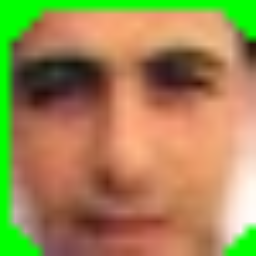

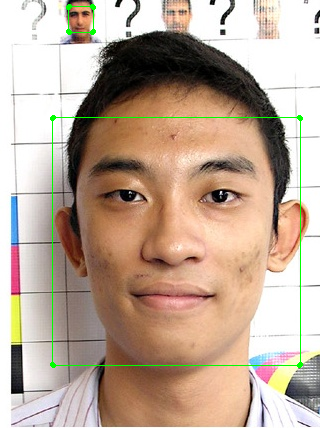

116 117
197 196
233 233
124 124
215 214
249 249
1490 1489
86 86
239 238
249 248
238 238
148 148
245 245
135 134
237 236
229 229
129 129
196 180
374 374
89 89
144 144
230 229
285 280
253 253
224 223
226 226
275 275
179 171
351 351
154 154
257 257
260 261
145 145
230 230
212 212
234 235
226 226
254 253
162 162
163 163
140 139
103 104
259 258
247 247
92 92
136 136
375 375
101 101
143 142
232 232
260 259
207 207
408 430
234 233
100 100
138 138
53 53
208 209
240 239
239 239
203 204
212 212
440 533
87 87
239 239
95 95
202 203
94 94
366 366
235 235
235 235
230 230
94 93
241 241
215 214
214 214
240 239
370 370
107 107
134 134
164 164
224 224
230 230
237 238
237 237
213 211
76 76
135 134
246 246
124 124
241 241
361 361
315 315
103 102
234 235
135 134
54 54
244 244
356 356
108 108
175 174
166 167
236 236
233 233
125 125
123 123
414 414
241 241
114 114
105 106
314 314
210 213
268 267
194 194
121 121
127 127
163 163
246 246
114 114
120 120
230 229
89 89
253 253
249 249
90 91
470 471
207 187
234 23

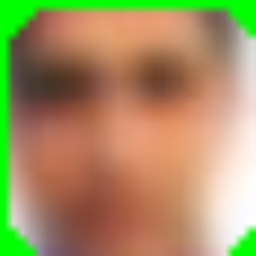

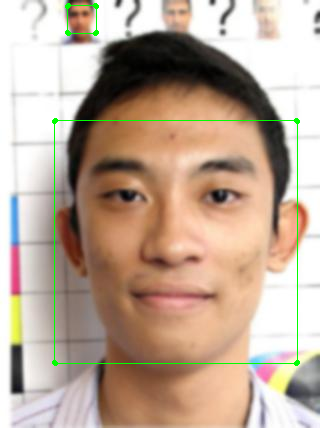

127 128
104 104
237 237
165 165
172 173
227 226
237 237
109 109
85 85
41 38


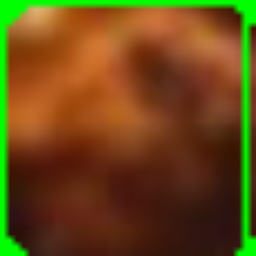

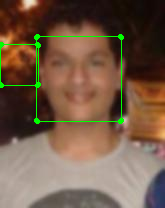

198 198
241 241
125 124
154 154
267 267
211 212
378 378
254 254
352 352
86 86
198 199
238 239
163 163
234 234
98 98
226 226
127 127
230 230
250 249
85 85
156 156
236 236
216 215
258 258
154 140
236 236
230 231
169 170
224 223
106 106
318 319
377 376
230 230
250 251
201 201
143 143
145 145
222 222
228 227
240 240
173 173
227 226
219 220
165 164
826 692
345 345
348 348
94 95
182 182
300 300
209 209
105 104
229 230
241 240
229 229
247 248
354 354
282 282
235 236
83 83
265 266
783 783
91 91
239 239
144 144
109 109
494 494
230 230
254 253
121 121
133 133
81 81
213 214
317 317
78 78
120 120
431 431
261 260
102 101
261 261
171 172
99 99
329 329
213 213
282 281
315 315
312 312
209 209
130 129
122 122
129 129
249 249
471 471
102 101
214 214
124 124
138 138
71 71
91 90
81 82
270 271
151 151
148 148
210 210
124 124
113 112
170 170
86 86
130 130
222 221
250 249
117 116
275 275
294 293
218 217
254 254
95 95
276 276
97 97
121 121
227 227
139 139
192 192
164 164
161 160
114 121
164 164
198 199
81 82


In [21]:
MODEL_SELECTION=1
detection = face_detection.FaceDetection(model_selection=MODEL_SELECTION,
                                         min_detection_confidence= CONFIDENCE)
images, labels = read_image_resize(dataset_folder, TARGET_SIZE, detection)

In [22]:
def create_sequential(no_of_classes, target_size=28):

    model = Sequential()

    # FIRST LAYER
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(target_size, target_size, 3)))
    model.add(MaxPooling2D())

    # SECOND LAYER
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())

    # THIRD LAYER
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))

    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    return model


model = create_sequential(NO_OF_CLASSES, TARGET_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

(664, 256, 256, 3)
(328, 256, 256, 3)
['without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', '

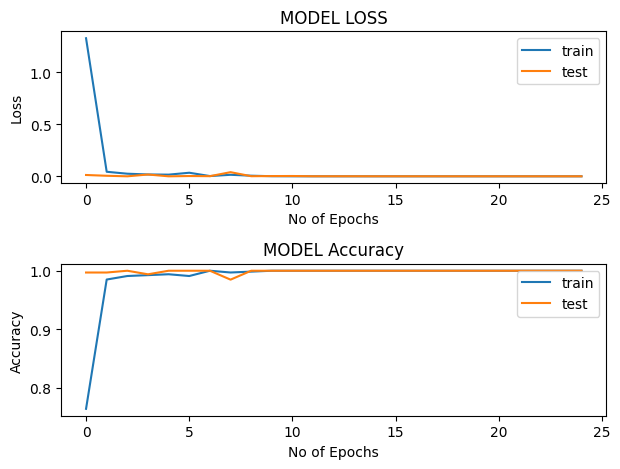

In [25]:



face_detection = mp.solutions.face_detection
draw_utils = mp.solutions.drawing_utils
draw_color = draw_utils.DrawingSpec((0,255,0), thickness=3, circle_radius = 1)
MODEL_SELECTION = 1
CONFIDENCE = 0.5

TARGET_SIZE = 256


x_train, x_test, y_train, y_test = split_train_test(images,
                                                    labels,
                                                    0.33,
                                                    TARGET_SIZE,
                                                    2)

print(labels)
NO_OF_CLASSES = 2
label_array = {'with_mask':0, 'without_mask':1}


y_train, y_test = one_hot_encode(y_train,
                                 y_test,
                                 label_array,
                                 NO_OF_CLASSES)


# 4. SIMPLE MODEL TO TRAIN..
     # 3 layes models...

model = create_sequential(NO_OF_CLASSES, TARGET_SIZE)

model.summary()


Epochs_to_train = 25

# 5. TRAIN the dataset with this MODEL..
model.fit(x_train, y_train,
          validation_data = ( x_test, y_test),
          epochs = Epochs_to_train)

# 6. PLOT and see how the model performs on this data
print(model.history.history)

history = model.history.history

plt.subplot(2, 1, 1)
plt.title("MODEL LOSS")
plt.ylabel("Loss")
plt.xlabel("No of Epochs")

plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.legend(['train', 'test'], loc='upper right')


plt.subplot(2, 1, 2)
plt.title("MODEL Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("No of Epochs")

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [26]:
def image_to_numpy(image, target_size=256):
    image_resize = cv.resize(image, (target_size, target_size))
    image_s = np.array(image_resize, dtype=object)
    image_s = image_s.reshape(1, target_size, target_size, 3)  # Add the missing comma
    image_s = image_s.astype('float32')
    image_s /= 255.0
    return image_s

In [27]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            context.drawImage(video, 0, 0, video.videoWidth, video.videoHeight);
            const dataUrl = canvas.toDataURL('image/jpeg', quality);

            stream.getVideoTracks()[0].stop();
            div.remove();
            return dataUrl;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 [==============================] - 0s 97ms/step


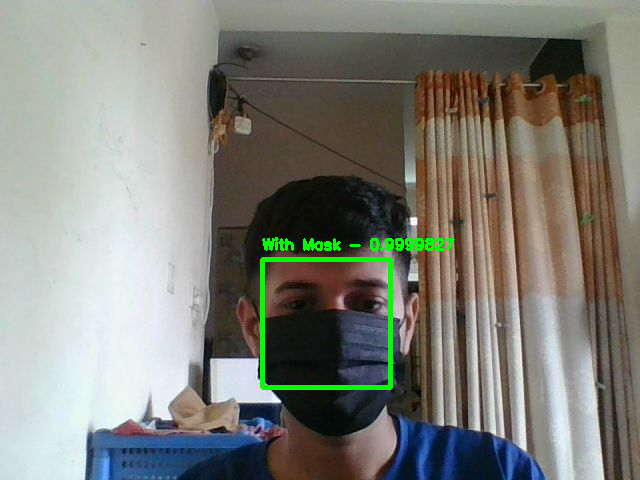

In [33]:
# Capture an image using the webcam
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Perform face detection on the captured image
    image = cv.imread(filename)
    image_convert = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    detection = face_detection.FaceDetection(min_detection_confidence=CONFIDENCE)
    outputs = detection.process(image_convert)

    if outputs.detections:
        for region in outputs.detections:
            left, top, right, bottom = get_bounding_rectangle(image, region, COLOR_GREEN, 2)

            crop_image = image[top:bottom, left:right]
            image_scaled = image_to_numpy(crop_image, TARGET_SIZE)  # Use crop_image instead of the full image
            result = model.predict(image_scaled)
            max_value = np.amax(result)
            class_index = np.argmax(result)  # Corrected line
            score = str(result[0][class_index])  # Corrected line
            detected_class = class_index

            if detected_class == 0:
                color = (0, 255, 0)  # Green for "With Mask"
                str_mask = "With Mask"
            else:
                color = (0, 0, 255)  # Red for "Without Mask"
                str_mask = "Without Mask"

            # Draw bounding box and label
            cv.rectangle(image, (left, top), (right, bottom), color, 3)
            cv.putText(image, f"{str_mask} - {score}", (left, top - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with detected faces and labels
    cv2_imshow(image)

except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
